In [1]:
import torch
import time
import pandas as pd
import numpy as np  
import os
import itertools
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from datasets import Dataset
from datasets import load_dataset, load_metric
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType, PrefixTuningConfig, IA3Config
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import wandb
WANDB_API_KEY = os.environ.get("WANDB_API_KEY", None)
wandb.login(key=WANDB_API_KEY)

/home/tico/anaconda3/envs/benchmark/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gonzalezmanfred309 (gatonegro). Use `wandb login --relogin` to force relogin


True

In [2]:
model_name = "EMBEDDIA/sloberta"
# Load the dataset
dataset = load_dataset('csv', data_files={
    'train': 'SuperGLUE-HumanT/csv/RTE/train.csv',
    'validation': 'SuperGLUE-HumanT/csv/RTE/val.csv'
})

# Tokenization
tokenizer = AutoTokenizer.from_pretrained(model_name)
def preprocess_function(examples):
    return tokenizer(examples['premise'], examples['hypothesis'], truncation=True, padding='max_length', max_length=512)
dataset = dataset.map(preprocess_function, batched=True)

# Here you split the validation set into validation and test sets
test_train_split = dataset['validation'].train_test_split(test_size=0.5)
# Now you need to add these new sets back into your dataset
dataset['validation'] = test_train_split['train']
dataset['test'] = test_train_split['test']

# Now continue with label mapping
def label_mapping(example):
    label_dict = {'not_entailment': 0, 'entailment': 1}
    example['labels'] = label_dict[example['label']]
    return example
dataset = dataset.map(label_mapping)

# Set format for PyTorch
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])



Map: 100%|██████████| 15/15 [00:00<00:00, 5690.54 examples/s]


In [3]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='weighted')  # Modify as needed
    accuracy = accuracy_score(labels, predictions)
    return {
        'f1': f1,
        'accuracy': accuracy
    }

In [4]:
def fine_tune_model(model_name, model, training_args, dataset):

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['validation'],
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
    )

    start = time.time()
    trainer.train()
    elapsed_training = time.time() - start

    metrics = trainer.evaluate(dataset['test'])

    print(f"model: {model_name}, Dataset: Sentinews, Test Metrics: {metrics}")

    model.save_pretrained(f"{model_name}_RTE_FINAL")

    return model, metrics, elapsed_training

In [6]:
def run_lora_sloberta(dataset):
    task_type = TaskType.SEQ_CLS  # You might need a different TaskType depending on your exact use case

    training_args = TrainingArguments(
        output_dir=f"{model_name}-RTE",  # Change as needed
        learning_rate=1e-4,
        per_device_train_batch_size=16,  # Adjust based on your GPU memory
        per_device_eval_batch_size=16,
        num_train_epochs=15,
        weight_decay=0.1,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True
    )

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Adjust num_labels as needed
    model = prepare_model_for_kbit_training(model, task_type)

    target_modules = (
        [
            "roberta.encoder.layer." + str(i) + ".attention.self.query"
            for i in range(model.config.num_hidden_layers)
        ]
        + [
            "roberta.encoder.layer." + str(i) + ".attention.self.key"
            for i in range(model.config.num_hidden_layers)
        ]
        + [
            "roberta.encoder.layer." + str(i) + ".attention.self.value"
            for i in range(model.config.num_hidden_layers)
        ]
        + [
            "roberta.encoder.layer." + str(i) + ".attention.output.dense"
            for i in range(model.config.num_hidden_layers)
        ]
    )
    
    lora_config = LoraConfig(
        r=16,
        lora_alpha=64,
        lora_dropout=0.05,
        task_type=task_type,
        bias="none",
        target_modules=target_modules,
    )

    model = get_peft_model(model, lora_config)
    print_trainable_parameters(model)
    
    _, metrics, elapsed_training = fine_tune_model(
        model_name, model, training_args, dataset
    )

    current_time = time.strftime("%Y-%m-%d-%H-%M-%S")
    with open("results.csv", "a") as f:
        f.write(
            f"{current_time},{model_name},sloberta-RTE,{metrics},{metrics},{elapsed_training}\n"
        )

# Assuming 'documents' is your dataset
# You'll need to convert 'documents' into a format compatible with Hugging Face datasets
run_lora_sloberta(dataset)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1771778 || all params: 112395268 || trainable%: 1.5763813117114502


  7%|▋         | 15/225 [00:02<00:38,  5.46it/s]

{'eval_loss': 0.721870481967926, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0753, 'eval_samples_per_second': 185.98, 'eval_steps_per_second': 13.284, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.44it/s]

{'eval_loss': 0.6745262742042542, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0753, 'eval_samples_per_second': 185.905, 'eval_steps_per_second': 13.279, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.43it/s]

{'eval_loss': 0.6697607040405273, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0756, 'eval_samples_per_second': 185.123, 'eval_steps_per_second': 13.223, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.43it/s]

{'eval_loss': 0.7017088532447815, 'eval_f1': 0.326984126984127, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0754, 'eval_samples_per_second': 185.765, 'eval_steps_per_second': 13.269, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.43it/s]

{'eval_loss': 0.6995837092399597, 'eval_f1': 0.36703296703296706, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0755, 'eval_samples_per_second': 185.535, 'eval_steps_per_second': 13.252, 'epoch': 5.0}


 33%|███▎      | 75/225 [00:15<00:30,  4.85it/s]


{'train_runtime': 15.4794, 'train_samples_per_second': 224.814, 'train_steps_per_second': 14.535, 'train_loss': 0.6939015706380208, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 609.28it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6952952742576599, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0797, 'eval_samples_per_second': 188.242, 'eval_steps_per_second': 12.549, 'epoch': 5.0}


In [5]:
def run_lora_sloberta(dataset,model_name):
    # Possible values for r, lora_alpha, and weight_decay
    r_values = [8, 16, 32]
    alpha_values = [16, 32, 64]
    weight_decay_values = [0.01, 0.1, 0.2]

    best_model = None
    best_metrics = None
    best_setup = None

    for r, alpha, weight_decay in itertools.product(r_values, alpha_values, weight_decay_values):
        print(f"Running configuration: r={r}, alpha={alpha}, weight_decay={weight_decay}")

        # Training arguments
        training_args = TrainingArguments(
            output_dir=f"results/{r}_{alpha}_{weight_decay}-RTE",
            learning_rate=1e-4,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=15,
            weight_decay=weight_decay,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True
        )

        # Model initialization
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
        lora_config = LoraConfig(
            r=r,
            lora_alpha=alpha,
            lora_dropout=0.05,
            task_type=TaskType.SEQ_CLS,
            bias="none",
            target_modules=[f"roberta.encoder.layer.{i}.attention.self.query" for i in range(model.config.num_hidden_layers)] + [f"roberta.encoder.layer.{i}.attention.self.key" for i in range(model.config.num_hidden_layers)] + [f"roberta.encoder.layer.{i}.attention.self.value" for i in range(model.config.num_hidden_layers)] + [f"roberta.encoder.layer.{i}.attention.output.dense" for i in range(model.config.num_hidden_layers)]
        )

        model = get_peft_model(model, lora_config)
        _, metrics, _ = fine_tune_model(model_name, model, training_args, dataset)

        # Logging results
        current_time = time.strftime("%Y-%m-%d-%H-%M-%S")
        if not os.path.isfile("results_cross_validation.csv"):
            with open("results_cross_validation.csv", "a") as f:
                f.write(f"current_time,model_name,r,alpha,weight_decay,eval_f1\n")
        with open("results_cross_validation.csv", "a") as f:
            f.write(f"{current_time},{model_name},{r},{alpha},{weight_decay},{metrics['eval_f1']}\n")

        # Update best model based on new metrics
        if best_metrics is None or metrics['eval_f1'] > best_metrics['eval_f1']:
            best_metrics = metrics
            best_model = model
            best_setup = (r, alpha, weight_decay)

    print(f"Best model setup: r={best_setup[0]}, alpha={best_setup[1]}, weight_decay={best_setup[2]} with F1 score: {best_metrics['eval_f1']}")
    return best_model, best_metrics
best_model, best_metrics = run_lora_sloberta(dataset,model_name)

Running configuration: r=8, alpha=16, weight_decay=0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                                                
  7%|▋         | 15/225 [00:03<00:38,  5.42it/s]

{'eval_loss': 0.7098490595817566, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0756, 'eval_samples_per_second': 185.159, 'eval_steps_per_second': 13.226, 'epoch': 1.0}


                                                
 13%|█▎        | 30/225 [00:06<00:35,  5.45it/s]

{'eval_loss': 0.6910701394081116, 'eval_f1': 0.5080213903743316, 'eval_accuracy': 0.5, 'eval_runtime': 0.0741, 'eval_samples_per_second': 188.968, 'eval_steps_per_second': 13.498, 'epoch': 2.0}


                                                
 20%|██        | 45/225 [00:09<00:33,  5.43it/s]

{'eval_loss': 0.6735808253288269, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0744, 'eval_samples_per_second': 188.252, 'eval_steps_per_second': 13.447, 'epoch': 3.0}


                                                
 27%|██▋       | 60/225 [00:12<00:30,  5.42it/s]

{'eval_loss': 0.696226954460144, 'eval_f1': 0.4438502673796792, 'eval_accuracy': 0.5, 'eval_runtime': 0.0758, 'eval_samples_per_second': 184.614, 'eval_steps_per_second': 13.187, 'epoch': 4.0}


                                                
 33%|███▎      | 75/225 [00:15<00:27,  5.44it/s]

{'eval_loss': 0.6935323476791382, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.518, 'eval_steps_per_second': 13.323, 'epoch': 5.0}


 33%|███▎      | 75/225 [00:16<00:32,  4.63it/s]


{'train_runtime': 18.195, 'train_samples_per_second': 191.261, 'train_steps_per_second': 12.366, 'train_loss': 0.6958412170410156, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 548.06it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.695906937122345, 'eval_f1': 0.4, 'eval_accuracy': 0.4, 'eval_runtime': 0.0832, 'eval_samples_per_second': 180.305, 'eval_steps_per_second': 12.02, 'epoch': 5.0}
Running configuration: r=8, alpha=16, weight_decay=0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.47it/s]

{'eval_loss': 0.7205066084861755, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.33, 'eval_steps_per_second': 13.309, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.42it/s]

{'eval_loss': 0.6853275895118713, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0749, 'eval_samples_per_second': 187.014, 'eval_steps_per_second': 13.358, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.39it/s]

{'eval_loss': 0.6725562214851379, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0764, 'eval_samples_per_second': 183.352, 'eval_steps_per_second': 13.097, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:11<00:30,  5.46it/s]

{'eval_loss': 0.7038952708244324, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0734, 'eval_samples_per_second': 190.733, 'eval_steps_per_second': 13.624, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.43it/s]

{'eval_loss': 0.704573929309845, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0758, 'eval_samples_per_second': 184.65, 'eval_steps_per_second': 13.189, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:24,  5.42it/s]

{'eval_loss': 0.6839855909347534, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0745, 'eval_samples_per_second': 187.889, 'eval_steps_per_second': 13.421, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:27,  4.88it/s]


{'train_runtime': 18.4451, 'train_samples_per_second': 188.668, 'train_steps_per_second': 12.198, 'train_loss': 0.6952740139431424, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 513.06it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6980372667312622, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.079, 'eval_samples_per_second': 189.778, 'eval_steps_per_second': 12.652, 'epoch': 6.0}
Running configuration: r=8, alpha=16, weight_decay=0.2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.43it/s]

{'eval_loss': 0.7126950025558472, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0754, 'eval_samples_per_second': 185.773, 'eval_steps_per_second': 13.27, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.43it/s]

{'eval_loss': 0.6981807947158813, 'eval_f1': 0.39285714285714285, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.469, 'eval_steps_per_second': 13.319, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.44it/s]

{'eval_loss': 0.6760600805282593, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0743, 'eval_samples_per_second': 188.386, 'eval_steps_per_second': 13.456, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.42it/s]

{'eval_loss': 0.6989546418190002, 'eval_f1': 0.39285714285714285, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.414, 'eval_steps_per_second': 13.315, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.40it/s]

{'eval_loss': 0.6965705156326294, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0762, 'eval_samples_per_second': 183.841, 'eval_steps_per_second': 13.132, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:24,  5.42it/s]

{'eval_loss': 0.6833759546279907, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0749, 'eval_samples_per_second': 186.876, 'eval_steps_per_second': 13.348, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:27,  4.84it/s]


{'train_runtime': 18.5905, 'train_samples_per_second': 187.192, 'train_steps_per_second': 12.103, 'train_loss': 0.6938941531711155, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 645.28it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6984625458717346, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0704, 'eval_samples_per_second': 213.177, 'eval_steps_per_second': 14.212, 'epoch': 6.0}
Running configuration: r=8, alpha=32, weight_decay=0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.46it/s]

{'eval_loss': 0.7096055746078491, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0744, 'eval_samples_per_second': 188.187, 'eval_steps_per_second': 13.442, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.44it/s]

{'eval_loss': 0.692543089389801, 'eval_f1': 0.5080213903743316, 'eval_accuracy': 0.5, 'eval_runtime': 0.0739, 'eval_samples_per_second': 189.388, 'eval_steps_per_second': 13.528, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.38it/s]

{'eval_loss': 0.6747926473617554, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0774, 'eval_samples_per_second': 180.856, 'eval_steps_per_second': 12.918, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.38it/s]

{'eval_loss': 0.6978782415390015, 'eval_f1': 0.4438502673796792, 'eval_accuracy': 0.5, 'eval_runtime': 0.0766, 'eval_samples_per_second': 182.886, 'eval_steps_per_second': 13.063, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.42it/s]

{'eval_loss': 0.6897382736206055, 'eval_f1': 0.7142857142857143, 'eval_accuracy': 0.7142857142857143, 'eval_runtime': 0.0763, 'eval_samples_per_second': 183.407, 'eval_steps_per_second': 13.101, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.40it/s]

{'eval_loss': 0.6789786219596863, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.467, 'eval_steps_per_second': 13.319, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.42it/s]

{'eval_loss': 0.6764946579933167, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0744, 'eval_samples_per_second': 188.158, 'eval_steps_per_second': 13.44, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:24<00:19,  5.42it/s]

{'eval_loss': 0.7020739316940308, 'eval_f1': 0.4404761904761904, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0761, 'eval_samples_per_second': 183.851, 'eval_steps_per_second': 13.132, 'epoch': 8.0}


 53%|█████▎    | 120/225 [00:24<00:21,  4.84it/s]


{'train_runtime': 24.8133, 'train_samples_per_second': 140.247, 'train_steps_per_second': 9.068, 'train_loss': 0.6894547780354817, 'epoch': 8.0}


100%|██████████| 1/1 [00:00<00:00, 646.57it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7004010677337646, 'eval_f1': 0.3273809523809524, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0768, 'eval_samples_per_second': 195.322, 'eval_steps_per_second': 13.021, 'epoch': 8.0}
Running configuration: r=8, alpha=32, weight_decay=0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.42it/s]

{'eval_loss': 0.7254667282104492, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0757, 'eval_samples_per_second': 184.999, 'eval_steps_per_second': 13.214, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.40it/s]

{'eval_loss': 0.6926645040512085, 'eval_f1': 0.5076923076923077, 'eval_accuracy': 0.5, 'eval_runtime': 0.0757, 'eval_samples_per_second': 185.014, 'eval_steps_per_second': 13.215, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.42it/s]

{'eval_loss': 0.6784406900405884, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0742, 'eval_samples_per_second': 188.786, 'eval_steps_per_second': 13.485, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.42it/s]

{'eval_loss': 0.7067795395851135, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0761, 'eval_samples_per_second': 184.024, 'eval_steps_per_second': 13.145, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.42it/s]

{'eval_loss': 0.6999770402908325, 'eval_f1': 0.326984126984127, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.255, 'eval_steps_per_second': 13.304, 'epoch': 5.0}


 33%|███▎      | 75/225 [00:15<00:31,  4.83it/s]


{'train_runtime': 15.5179, 'train_samples_per_second': 224.258, 'train_steps_per_second': 14.499, 'train_loss': 0.6952230834960937, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 653.93it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6982908844947815, 'eval_f1': 0.46190476190476193, 'eval_accuracy': 0.4666666666666667, 'eval_runtime': 0.0769, 'eval_samples_per_second': 195.0, 'eval_steps_per_second': 13.0, 'epoch': 5.0}
Running configuration: r=8, alpha=32, weight_decay=0.2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.46it/s]

{'eval_loss': 0.7227001190185547, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.075, 'eval_samples_per_second': 186.672, 'eval_steps_per_second': 13.334, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.43it/s]

{'eval_loss': 0.6843100786209106, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0779, 'eval_samples_per_second': 179.68, 'eval_steps_per_second': 12.834, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.44it/s]

{'eval_loss': 0.6672350168228149, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0744, 'eval_samples_per_second': 188.264, 'eval_steps_per_second': 13.447, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.44it/s]

{'eval_loss': 0.7039594054222107, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0778, 'eval_samples_per_second': 179.982, 'eval_steps_per_second': 12.856, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.40it/s]

{'eval_loss': 0.6917168498039246, 'eval_f1': 0.6336996336996338, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0766, 'eval_samples_per_second': 182.871, 'eval_steps_per_second': 13.062, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:24,  5.42it/s]

{'eval_loss': 0.685188889503479, 'eval_f1': 0.5392857142857143, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0742, 'eval_samples_per_second': 188.772, 'eval_steps_per_second': 13.484, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.42it/s]

{'eval_loss': 0.6746082305908203, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.077, 'eval_steps_per_second': 13.291, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:24<00:19,  5.42it/s]

{'eval_loss': 0.6965389847755432, 'eval_f1': 0.5803571428571429, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0754, 'eval_samples_per_second': 185.785, 'eval_steps_per_second': 13.27, 'epoch': 8.0}


 53%|█████▎    | 120/225 [00:24<00:21,  4.85it/s]


{'train_runtime': 24.7397, 'train_samples_per_second': 140.665, 'train_steps_per_second': 9.095, 'train_loss': 0.6900156021118165, 'epoch': 8.0}


100%|██████████| 1/1 [00:00<00:00, 453.10it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7003689408302307, 'eval_f1': 0.15555555555555553, 'eval_accuracy': 0.2, 'eval_runtime': 0.0797, 'eval_samples_per_second': 188.108, 'eval_steps_per_second': 12.541, 'epoch': 8.0}
Running configuration: r=8, alpha=64, weight_decay=0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.44it/s]

{'eval_loss': 0.7259243726730347, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.076, 'eval_samples_per_second': 184.172, 'eval_steps_per_second': 13.155, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.44it/s]

{'eval_loss': 0.6905880570411682, 'eval_f1': 0.4853801169590643, 'eval_accuracy': 0.5, 'eval_runtime': 0.0746, 'eval_samples_per_second': 187.599, 'eval_steps_per_second': 13.4, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.43it/s]

{'eval_loss': 0.6724501252174377, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0773, 'eval_samples_per_second': 181.035, 'eval_steps_per_second': 12.931, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.42it/s]

{'eval_loss': 0.7228110432624817, 'eval_f1': 0.326984126984127, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.09, 'eval_steps_per_second': 13.292, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.42it/s]

{'eval_loss': 0.7133721709251404, 'eval_f1': 0.2849503437738732, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.422, 'eval_steps_per_second': 13.316, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:24,  5.43it/s]

{'eval_loss': 0.6775462031364441, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0753, 'eval_samples_per_second': 186.017, 'eval_steps_per_second': 13.287, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:27,  4.85it/s]


{'train_runtime': 18.5717, 'train_samples_per_second': 187.382, 'train_steps_per_second': 12.115, 'train_loss': 0.6955607520209418, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 571.28it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6938593983650208, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0788, 'eval_samples_per_second': 190.239, 'eval_steps_per_second': 12.683, 'epoch': 6.0}
Running configuration: r=8, alpha=64, weight_decay=0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.43it/s]

{'eval_loss': 0.7133427262306213, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0763, 'eval_samples_per_second': 183.533, 'eval_steps_per_second': 13.11, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.44it/s]

{'eval_loss': 0.6995368599891663, 'eval_f1': 0.39285714285714285, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0768, 'eval_samples_per_second': 182.39, 'eval_steps_per_second': 13.028, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.45it/s]

{'eval_loss': 0.671510636806488, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0741, 'eval_samples_per_second': 188.826, 'eval_steps_per_second': 13.488, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.44it/s]

{'eval_loss': 0.6937151551246643, 'eval_f1': 0.5446428571428571, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0745, 'eval_samples_per_second': 187.947, 'eval_steps_per_second': 13.425, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.38it/s]

{'eval_loss': 0.7023391127586365, 'eval_f1': 0.326984126984127, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0729, 'eval_samples_per_second': 192.099, 'eval_steps_per_second': 13.721, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:24,  5.47it/s]

{'eval_loss': 0.6773987412452698, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.073, 'eval_samples_per_second': 191.856, 'eval_steps_per_second': 13.704, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:21,  5.51it/s]

{'eval_loss': 0.671134889125824, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0723, 'eval_samples_per_second': 193.576, 'eval_steps_per_second': 13.827, 'epoch': 7.0}


 47%|████▋     | 105/225 [00:21<00:24,  4.87it/s]


{'train_runtime': 21.5702, 'train_samples_per_second': 161.334, 'train_steps_per_second': 10.431, 'train_loss': 0.6899379185267858, 'epoch': 7.0}


100%|██████████| 1/1 [00:00<00:00, 675.74it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7083041071891785, 'eval_f1': 0.15555555555555553, 'eval_accuracy': 0.2, 'eval_runtime': 0.0762, 'eval_samples_per_second': 196.743, 'eval_steps_per_second': 13.116, 'epoch': 7.0}
Running configuration: r=8, alpha=64, weight_decay=0.2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:37,  5.55it/s]

{'eval_loss': 0.7139724493026733, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0722, 'eval_samples_per_second': 193.828, 'eval_steps_per_second': 13.845, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.50it/s]

{'eval_loss': 0.6843830943107605, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0725, 'eval_samples_per_second': 193.044, 'eval_steps_per_second': 13.789, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:32,  5.51it/s]

{'eval_loss': 0.6769543290138245, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0724, 'eval_samples_per_second': 193.314, 'eval_steps_per_second': 13.808, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:11<00:30,  5.49it/s]

{'eval_loss': 0.6987971067428589, 'eval_f1': 0.4404761904761904, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0722, 'eval_samples_per_second': 193.851, 'eval_steps_per_second': 13.846, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:14<00:27,  5.52it/s]

{'eval_loss': 0.6831064820289612, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0729, 'eval_samples_per_second': 192.149, 'eval_steps_per_second': 13.725, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:24,  5.53it/s]

{'eval_loss': 0.7061878442764282, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.5, 'eval_runtime': 0.0727, 'eval_samples_per_second': 192.513, 'eval_steps_per_second': 13.751, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:27,  4.90it/s]


{'train_runtime': 18.3654, 'train_samples_per_second': 189.487, 'train_steps_per_second': 12.251, 'train_loss': 0.6884680430094401, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 683.00it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6987859010696411, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0761, 'eval_samples_per_second': 197.131, 'eval_steps_per_second': 13.142, 'epoch': 6.0}
Running configuration: r=16, alpha=16, weight_decay=0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:37,  5.54it/s]

{'eval_loss': 0.7091732025146484, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0727, 'eval_samples_per_second': 192.698, 'eval_steps_per_second': 13.764, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:35,  5.48it/s]

{'eval_loss': 0.6978014707565308, 'eval_f1': 0.4438502673796792, 'eval_accuracy': 0.5, 'eval_runtime': 0.0726, 'eval_samples_per_second': 192.913, 'eval_steps_per_second': 13.78, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:32,  5.52it/s]

{'eval_loss': 0.6730976700782776, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0728, 'eval_samples_per_second': 192.404, 'eval_steps_per_second': 13.743, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:11<00:30,  5.49it/s]

{'eval_loss': 0.6961974501609802, 'eval_f1': 0.4871794871794872, 'eval_accuracy': 0.5, 'eval_runtime': 0.0731, 'eval_samples_per_second': 191.647, 'eval_steps_per_second': 13.689, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.48it/s]

{'eval_loss': 0.6996792554855347, 'eval_f1': 0.39285714285714285, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0723, 'eval_samples_per_second': 193.734, 'eval_steps_per_second': 13.838, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:24,  5.51it/s]

{'eval_loss': 0.6871954202651978, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.5, 'eval_runtime': 0.0727, 'eval_samples_per_second': 192.449, 'eval_steps_per_second': 13.746, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:27,  4.86it/s]


{'train_runtime': 18.5395, 'train_samples_per_second': 187.708, 'train_steps_per_second': 12.136, 'train_loss': 0.6942056443956163, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 517.82it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6975468397140503, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.078, 'eval_samples_per_second': 192.333, 'eval_steps_per_second': 12.822, 'epoch': 6.0}
Running configuration: r=16, alpha=16, weight_decay=0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.41it/s]

{'eval_loss': 0.7090197801589966, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0744, 'eval_samples_per_second': 188.187, 'eval_steps_per_second': 13.442, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.37it/s]

{'eval_loss': 0.6978760957717896, 'eval_f1': 0.4438502673796792, 'eval_accuracy': 0.5, 'eval_runtime': 0.0762, 'eval_samples_per_second': 183.714, 'eval_steps_per_second': 13.122, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:28,  6.24it/s]

{'eval_loss': 0.6736050248146057, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0771, 'eval_samples_per_second': 181.51, 'eval_steps_per_second': 12.965, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:26,  6.17it/s]

{'eval_loss': 0.6989040970802307, 'eval_f1': 0.4871794871794872, 'eval_accuracy': 0.5, 'eval_runtime': 0.0786, 'eval_samples_per_second': 178.092, 'eval_steps_per_second': 12.721, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:28,  5.34it/s]

{'eval_loss': 0.7047691941261292, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0761, 'eval_samples_per_second': 183.958, 'eval_steps_per_second': 13.14, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.28it/s]

{'eval_loss': 0.6829825043678284, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0774, 'eval_samples_per_second': 180.879, 'eval_steps_per_second': 12.92, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:28,  4.76it/s]


{'train_runtime': 18.896, 'train_samples_per_second': 184.166, 'train_steps_per_second': 11.907, 'train_loss': 0.6936984592013888, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 628.74it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.698993444442749, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0771, 'eval_samples_per_second': 194.55, 'eval_steps_per_second': 12.97, 'epoch': 6.0}
Running configuration: r=16, alpha=16, weight_decay=0.2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:39,  5.38it/s]

{'eval_loss': 0.7091493010520935, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0779, 'eval_samples_per_second': 179.744, 'eval_steps_per_second': 12.839, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.37it/s]

{'eval_loss': 0.6978355050086975, 'eval_f1': 0.4438502673796792, 'eval_accuracy': 0.5, 'eval_runtime': 0.0755, 'eval_samples_per_second': 185.522, 'eval_steps_per_second': 13.252, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:28,  6.24it/s]

{'eval_loss': 0.6763976216316223, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0761, 'eval_samples_per_second': 184.039, 'eval_steps_per_second': 13.146, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.36it/s]

{'eval_loss': 0.6991179585456848, 'eval_f1': 0.4871794871794872, 'eval_accuracy': 0.5, 'eval_runtime': 0.0757, 'eval_samples_per_second': 184.997, 'eval_steps_per_second': 13.214, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.40it/s]

{'eval_loss': 0.7019885182380676, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0743, 'eval_samples_per_second': 188.507, 'eval_steps_per_second': 13.465, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:24,  5.40it/s]

{'eval_loss': 0.6888560652732849, 'eval_f1': 0.5392857142857143, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0746, 'eval_samples_per_second': 187.716, 'eval_steps_per_second': 13.408, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.40it/s]

{'eval_loss': 0.6778243780136108, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0771, 'eval_samples_per_second': 181.614, 'eval_steps_per_second': 12.972, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:24<00:19,  5.38it/s]

{'eval_loss': 0.7006495594978333, 'eval_f1': 0.36703296703296706, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0761, 'eval_samples_per_second': 184.063, 'eval_steps_per_second': 13.147, 'epoch': 8.0}


 60%|██████    | 135/225 [00:27<00:16,  5.39it/s]

{'eval_loss': 0.695084273815155, 'eval_f1': 0.4853801169590643, 'eval_accuracy': 0.5, 'eval_runtime': 0.0773, 'eval_samples_per_second': 181.044, 'eval_steps_per_second': 12.932, 'epoch': 9.0}


 60%|██████    | 135/225 [00:28<00:18,  4.81it/s]


{'train_runtime': 28.0418, 'train_samples_per_second': 124.101, 'train_steps_per_second': 8.024, 'train_loss': 0.6911764074254919, 'epoch': 9.0}


100%|██████████| 1/1 [00:00<00:00, 635.69it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7041863799095154, 'eval_f1': 0.45185185185185184, 'eval_accuracy': 0.4666666666666667, 'eval_runtime': 0.0783, 'eval_samples_per_second': 191.627, 'eval_steps_per_second': 12.775, 'epoch': 9.0}
Running configuration: r=16, alpha=32, weight_decay=0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.43it/s]

{'eval_loss': 0.7214345335960388, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0772, 'eval_samples_per_second': 181.304, 'eval_steps_per_second': 12.95, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.40it/s]

{'eval_loss': 0.6884593367576599, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0764, 'eval_samples_per_second': 183.241, 'eval_steps_per_second': 13.089, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.40it/s]

{'eval_loss': 0.6747470498085022, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0742, 'eval_samples_per_second': 188.608, 'eval_steps_per_second': 13.472, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.40it/s]

{'eval_loss': 0.6975724101066589, 'eval_f1': 0.24107142857142858, 'eval_accuracy': 0.2857142857142857, 'eval_runtime': 0.0745, 'eval_samples_per_second': 187.858, 'eval_steps_per_second': 13.418, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.40it/s]

{'eval_loss': 0.6971350312232971, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0762, 'eval_samples_per_second': 183.776, 'eval_steps_per_second': 13.127, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:21,  6.25it/s]

{'eval_loss': 0.6933501958847046, 'eval_f1': 0.3857142857142857, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0761, 'eval_samples_per_second': 184.027, 'eval_steps_per_second': 13.145, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:27,  4.84it/s]


{'train_runtime': 18.6131, 'train_samples_per_second': 186.965, 'train_steps_per_second': 12.088, 'train_loss': 0.6950265248616536, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 616.45it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6959763169288635, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0795, 'eval_samples_per_second': 188.68, 'eval_steps_per_second': 12.579, 'epoch': 6.0}
Running configuration: r=16, alpha=32, weight_decay=0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.41it/s]

{'eval_loss': 0.7152448892593384, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0764, 'eval_samples_per_second': 183.256, 'eval_steps_per_second': 13.09, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.38it/s]

{'eval_loss': 0.6913670301437378, 'eval_f1': 0.5714285714285714, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0754, 'eval_samples_per_second': 185.569, 'eval_steps_per_second': 13.255, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.38it/s]

{'eval_loss': 0.6738468408584595, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.076, 'eval_samples_per_second': 184.206, 'eval_steps_per_second': 13.158, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.39it/s]

{'eval_loss': 0.7022537589073181, 'eval_f1': 0.2849503437738732, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0773, 'eval_samples_per_second': 181.019, 'eval_steps_per_second': 12.93, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.40it/s]

{'eval_loss': 0.7045459151268005, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.34, 'eval_steps_per_second': 13.31, 'epoch': 5.0}


 33%|███▎      | 75/225 [00:15<00:31,  4.79it/s]


{'train_runtime': 15.6506, 'train_samples_per_second': 222.355, 'train_steps_per_second': 14.376, 'train_loss': 0.6958411661783854, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 528.45it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6973943114280701, 'eval_f1': 0.45185185185185184, 'eval_accuracy': 0.4666666666666667, 'eval_runtime': 0.0813, 'eval_samples_per_second': 184.496, 'eval_steps_per_second': 12.3, 'epoch': 5.0}
Running configuration: r=16, alpha=32, weight_decay=0.2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.43it/s]

{'eval_loss': 0.7200618982315063, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0754, 'eval_samples_per_second': 185.742, 'eval_steps_per_second': 13.267, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.40it/s]

{'eval_loss': 0.6801170110702515, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0789, 'eval_samples_per_second': 177.533, 'eval_steps_per_second': 12.681, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.36it/s]

{'eval_loss': 0.6719026565551758, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0778, 'eval_samples_per_second': 179.867, 'eval_steps_per_second': 12.848, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.39it/s]

{'eval_loss': 0.6996119618415833, 'eval_f1': 0.326984126984127, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0773, 'eval_samples_per_second': 181.052, 'eval_steps_per_second': 12.932, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.38it/s]

{'eval_loss': 0.709846556186676, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0753, 'eval_samples_per_second': 185.888, 'eval_steps_per_second': 13.278, 'epoch': 5.0}


 33%|███▎      | 75/225 [00:15<00:31,  4.80it/s]


{'train_runtime': 15.6138, 'train_samples_per_second': 222.88, 'train_steps_per_second': 14.41, 'train_loss': 0.6956817626953125, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 572.44it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6972855925559998, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0786, 'eval_samples_per_second': 190.824, 'eval_steps_per_second': 12.722, 'epoch': 5.0}
Running configuration: r=16, alpha=64, weight_decay=0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.41it/s]

{'eval_loss': 0.7188717722892761, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0784, 'eval_samples_per_second': 178.586, 'eval_steps_per_second': 12.756, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.41it/s]

{'eval_loss': 0.6833864450454712, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0773, 'eval_samples_per_second': 181.149, 'eval_steps_per_second': 12.939, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.41it/s]

{'eval_loss': 0.6829904317855835, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0768, 'eval_samples_per_second': 182.358, 'eval_steps_per_second': 13.026, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.39it/s]

{'eval_loss': 0.7043970823287964, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0746, 'eval_samples_per_second': 187.726, 'eval_steps_per_second': 13.409, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.36it/s]

{'eval_loss': 0.689477264881134, 'eval_f1': 0.5714285714285714, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0744, 'eval_samples_per_second': 188.252, 'eval_steps_per_second': 13.447, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.38it/s]

{'eval_loss': 0.6853827834129333, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.5, 'eval_runtime': 0.0761, 'eval_samples_per_second': 183.951, 'eval_steps_per_second': 13.139, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.36it/s]

{'eval_loss': 0.6746057271957397, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0764, 'eval_samples_per_second': 183.224, 'eval_steps_per_second': 13.087, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:24<00:19,  5.39it/s]

{'eval_loss': 0.6985159516334534, 'eval_f1': 0.5080213903743316, 'eval_accuracy': 0.5, 'eval_runtime': 0.076, 'eval_samples_per_second': 184.291, 'eval_steps_per_second': 13.164, 'epoch': 8.0}


 53%|█████▎    | 120/225 [00:25<00:22,  4.76it/s]


{'train_runtime': 25.2135, 'train_samples_per_second': 138.021, 'train_steps_per_second': 8.924, 'train_loss': 0.6863677978515625, 'epoch': 8.0}


100%|██████████| 1/1 [00:00<00:00, 661.77it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7067225575447083, 'eval_f1': 0.3273809523809524, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0774, 'eval_samples_per_second': 193.691, 'eval_steps_per_second': 12.913, 'epoch': 8.0}
Running configuration: r=16, alpha=64, weight_decay=0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.42it/s]

{'eval_loss': 0.7266017198562622, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0743, 'eval_samples_per_second': 188.34, 'eval_steps_per_second': 13.453, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.39it/s]

{'eval_loss': 0.6869415640830994, 'eval_f1': 0.5714285714285714, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0754, 'eval_samples_per_second': 185.704, 'eval_steps_per_second': 13.265, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.39it/s]

{'eval_loss': 0.6715039610862732, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0773, 'eval_samples_per_second': 181.212, 'eval_steps_per_second': 12.944, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.38it/s]

{'eval_loss': 0.7094218134880066, 'eval_f1': 0.2849503437738732, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.076, 'eval_samples_per_second': 184.153, 'eval_steps_per_second': 13.154, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.39it/s]

{'eval_loss': 0.7018560171127319, 'eval_f1': 0.24107142857142858, 'eval_accuracy': 0.2857142857142857, 'eval_runtime': 0.0765, 'eval_samples_per_second': 183.007, 'eval_steps_per_second': 13.072, 'epoch': 5.0}


 33%|███▎      | 75/225 [00:15<00:31,  4.83it/s]


{'train_runtime': 15.5465, 'train_samples_per_second': 223.844, 'train_steps_per_second': 14.473, 'train_loss': 0.6956355285644531, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 588.76it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6958453059196472, 'eval_f1': 0.5291101055806938, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0794, 'eval_samples_per_second': 188.942, 'eval_steps_per_second': 12.596, 'epoch': 5.0}
Running configuration: r=16, alpha=64, weight_decay=0.2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.39it/s]

{'eval_loss': 0.7208232283592224, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0754, 'eval_samples_per_second': 185.649, 'eval_steps_per_second': 13.261, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.38it/s]

{'eval_loss': 0.6870040893554688, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0745, 'eval_samples_per_second': 188.034, 'eval_steps_per_second': 13.431, 'epoch': 2.0}


 20%|██        | 45/225 [00:08<00:33,  5.40it/s]

{'eval_loss': 0.6680383086204529, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0744, 'eval_samples_per_second': 188.127, 'eval_steps_per_second': 13.438, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.39it/s]

{'eval_loss': 0.6956745386123657, 'eval_f1': 0.5446428571428571, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0757, 'eval_samples_per_second': 184.993, 'eval_steps_per_second': 13.214, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.42it/s]

{'eval_loss': 0.6882377862930298, 'eval_f1': 0.4853801169590643, 'eval_accuracy': 0.5, 'eval_runtime': 0.0756, 'eval_samples_per_second': 185.089, 'eval_steps_per_second': 13.221, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.40it/s]

{'eval_loss': 0.6773061156272888, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0783, 'eval_samples_per_second': 178.852, 'eval_steps_per_second': 12.775, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.40it/s]

{'eval_loss': 0.6823797225952148, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.5, 'eval_runtime': 0.1026, 'eval_samples_per_second': 136.47, 'eval_steps_per_second': 9.748, 'epoch': 7.0}


 47%|████▋     | 105/225 [00:21<00:24,  4.82it/s]


{'train_runtime': 21.7862, 'train_samples_per_second': 159.734, 'train_steps_per_second': 10.328, 'train_loss': 0.687446521577381, 'epoch': 7.0}


100%|██████████| 1/1 [00:00<00:00, 481.05it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7031441926956177, 'eval_f1': 0.15555555555555553, 'eval_accuracy': 0.2, 'eval_runtime': 0.0832, 'eval_samples_per_second': 180.199, 'eval_steps_per_second': 12.013, 'epoch': 7.0}
Running configuration: r=32, alpha=16, weight_decay=0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.40it/s]

{'eval_loss': 0.7109931707382202, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0766, 'eval_samples_per_second': 182.885, 'eval_steps_per_second': 13.063, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:06<00:36,  5.36it/s]

{'eval_loss': 0.6927403807640076, 'eval_f1': 0.3857142857142857, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0763, 'eval_samples_per_second': 183.532, 'eval_steps_per_second': 13.109, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.33it/s]

{'eval_loss': 0.6785297989845276, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.192, 'eval_steps_per_second': 13.299, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.36it/s]

{'eval_loss': 0.6997207403182983, 'eval_f1': 0.4438502673796792, 'eval_accuracy': 0.5, 'eval_runtime': 0.0749, 'eval_samples_per_second': 186.846, 'eval_steps_per_second': 13.346, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:24,  6.19it/s]

{'eval_loss': 0.7006984353065491, 'eval_f1': 0.4438502673796792, 'eval_accuracy': 0.5, 'eval_runtime': 0.0776, 'eval_samples_per_second': 180.446, 'eval_steps_per_second': 12.889, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.35it/s]

{'eval_loss': 0.6881717443466187, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.5, 'eval_runtime': 0.0788, 'eval_samples_per_second': 177.683, 'eval_steps_per_second': 12.692, 'epoch': 6.0}


 40%|████      | 90/225 [00:19<00:29,  4.65it/s]


{'train_runtime': 19.3615, 'train_samples_per_second': 179.738, 'train_steps_per_second': 11.621, 'train_loss': 0.6939448886447482, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 526.72it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6944872736930847, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0794, 'eval_samples_per_second': 188.861, 'eval_steps_per_second': 12.591, 'epoch': 6.0}
Running configuration: r=32, alpha=16, weight_decay=0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.39it/s]

{'eval_loss': 0.7103155851364136, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0753, 'eval_samples_per_second': 185.98, 'eval_steps_per_second': 13.284, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:06<00:36,  5.35it/s]

{'eval_loss': 0.697986900806427, 'eval_f1': 0.4871794871794872, 'eval_accuracy': 0.5, 'eval_runtime': 0.0758, 'eval_samples_per_second': 184.784, 'eval_steps_per_second': 13.199, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.35it/s]

{'eval_loss': 0.6753636002540588, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.078, 'eval_samples_per_second': 179.455, 'eval_steps_per_second': 12.818, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.38it/s]

{'eval_loss': 0.699618935585022, 'eval_f1': 0.4871794871794872, 'eval_accuracy': 0.5, 'eval_runtime': 0.0763, 'eval_samples_per_second': 183.533, 'eval_steps_per_second': 13.11, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.40it/s]

{'eval_loss': 0.7027581930160522, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.093, 'eval_steps_per_second': 13.292, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.38it/s]

{'eval_loss': 0.6855058670043945, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0756, 'eval_samples_per_second': 185.143, 'eval_steps_per_second': 13.225, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:28,  4.77it/s]


{'train_runtime': 18.88, 'train_samples_per_second': 184.322, 'train_steps_per_second': 11.917, 'train_loss': 0.6939122517903645, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 561.86it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6993198990821838, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0798, 'eval_samples_per_second': 187.865, 'eval_steps_per_second': 12.524, 'epoch': 6.0}
Running configuration: r=32, alpha=16, weight_decay=0.2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.39it/s]

{'eval_loss': 0.7103118300437927, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0766, 'eval_samples_per_second': 182.733, 'eval_steps_per_second': 13.052, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.38it/s]

{'eval_loss': 0.6983329057693481, 'eval_f1': 0.39285714285714285, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0751, 'eval_samples_per_second': 186.418, 'eval_steps_per_second': 13.316, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.38it/s]

{'eval_loss': 0.6745993494987488, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0759, 'eval_samples_per_second': 184.403, 'eval_steps_per_second': 13.172, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.36it/s]

{'eval_loss': 0.6955315470695496, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0767, 'eval_samples_per_second': 182.556, 'eval_steps_per_second': 13.04, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:24,  6.24it/s]

{'eval_loss': 0.7083195447921753, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0748, 'eval_samples_per_second': 187.092, 'eval_steps_per_second': 13.364, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.36it/s]

{'eval_loss': 0.6870623230934143, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0765, 'eval_samples_per_second': 183.014, 'eval_steps_per_second': 13.072, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:28,  4.78it/s]


{'train_runtime': 18.8408, 'train_samples_per_second': 184.706, 'train_steps_per_second': 11.942, 'train_loss': 0.6943598853217231, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 514.13it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6992098689079285, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0815, 'eval_samples_per_second': 184.073, 'eval_steps_per_second': 12.272, 'epoch': 6.0}
Running configuration: r=32, alpha=32, weight_decay=0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.40it/s]

{'eval_loss': 0.7109977006912231, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0779, 'eval_samples_per_second': 179.655, 'eval_steps_per_second': 12.832, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.35it/s]

{'eval_loss': 0.6938934922218323, 'eval_f1': 0.4853801169590643, 'eval_accuracy': 0.5, 'eval_runtime': 0.0774, 'eval_samples_per_second': 180.805, 'eval_steps_per_second': 12.915, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.39it/s]

{'eval_loss': 0.676758885383606, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0762, 'eval_samples_per_second': 183.721, 'eval_steps_per_second': 13.123, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.35it/s]

{'eval_loss': 0.6997486352920532, 'eval_f1': 0.39285714285714285, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0776, 'eval_samples_per_second': 180.483, 'eval_steps_per_second': 12.892, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.38it/s]

{'eval_loss': 0.6926826238632202, 'eval_f1': 0.4853801169590643, 'eval_accuracy': 0.5, 'eval_runtime': 0.0763, 'eval_samples_per_second': 183.575, 'eval_steps_per_second': 13.113, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.35it/s]

{'eval_loss': 0.6823939085006714, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.07, 'eval_steps_per_second': 13.291, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:28,  4.75it/s]


{'train_runtime': 18.9349, 'train_samples_per_second': 183.788, 'train_steps_per_second': 11.883, 'train_loss': 0.6927539401584202, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 417.63it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.697856068611145, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0826, 'eval_samples_per_second': 181.608, 'eval_steps_per_second': 12.107, 'epoch': 6.0}
Running configuration: r=32, alpha=32, weight_decay=0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:39,  5.37it/s]

{'eval_loss': 0.7108291983604431, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0747, 'eval_samples_per_second': 187.4, 'eval_steps_per_second': 13.386, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.36it/s]

{'eval_loss': 0.6979449987411499, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0765, 'eval_samples_per_second': 182.966, 'eval_steps_per_second': 13.069, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.36it/s]

{'eval_loss': 0.6763477325439453, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0767, 'eval_samples_per_second': 182.476, 'eval_steps_per_second': 13.034, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.38it/s]

{'eval_loss': 0.6900200247764587, 'eval_f1': 0.4853801169590643, 'eval_accuracy': 0.5, 'eval_runtime': 0.0757, 'eval_samples_per_second': 185.049, 'eval_steps_per_second': 13.218, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.38it/s]

{'eval_loss': 0.6960814595222473, 'eval_f1': 0.5714285714285714, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0771, 'eval_samples_per_second': 181.673, 'eval_steps_per_second': 12.977, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.37it/s]

{'eval_loss': 0.6778166890144348, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0779, 'eval_samples_per_second': 179.82, 'eval_steps_per_second': 12.844, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.37it/s]

{'eval_loss': 0.6820345520973206, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0763, 'eval_samples_per_second': 183.503, 'eval_steps_per_second': 13.107, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:24<00:19,  5.39it/s]

{'eval_loss': 0.7085160613059998, 'eval_f1': 0.4404761904761904, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0752, 'eval_samples_per_second': 186.289, 'eval_steps_per_second': 13.306, 'epoch': 8.0}


 53%|█████▎    | 120/225 [00:24<00:21,  4.80it/s]


{'train_runtime': 25.0031, 'train_samples_per_second': 139.183, 'train_steps_per_second': 8.999, 'train_loss': 0.6887503306070963, 'epoch': 8.0}


100%|██████████| 1/1 [00:00<00:00, 458.39it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7094832062721252, 'eval_f1': 0.3273809523809524, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.0823, 'eval_samples_per_second': 182.168, 'eval_steps_per_second': 12.145, 'epoch': 8.0}
Running configuration: r=32, alpha=32, weight_decay=0.2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:39,  5.36it/s]

{'eval_loss': 0.7255970239639282, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0769, 'eval_samples_per_second': 181.99, 'eval_steps_per_second': 12.999, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.37it/s]

{'eval_loss': 0.6963289976119995, 'eval_f1': 0.4871794871794872, 'eval_accuracy': 0.5, 'eval_runtime': 0.077, 'eval_samples_per_second': 181.851, 'eval_steps_per_second': 12.989, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:28,  6.21it/s]

{'eval_loss': 0.6733693480491638, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0764, 'eval_samples_per_second': 183.319, 'eval_steps_per_second': 13.094, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.37it/s]

{'eval_loss': 0.7023986577987671, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0784, 'eval_samples_per_second': 178.536, 'eval_steps_per_second': 12.753, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:24,  6.20it/s]

{'eval_loss': 0.7038529515266418, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0766, 'eval_samples_per_second': 182.728, 'eval_steps_per_second': 13.052, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.34it/s]

{'eval_loss': 0.6826092004776001, 'eval_f1': 0.4675324675324676, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.0767, 'eval_samples_per_second': 182.612, 'eval_steps_per_second': 13.044, 'epoch': 6.0}


 40%|████      | 90/225 [00:18<00:28,  4.78it/s]


{'train_runtime': 18.834, 'train_samples_per_second': 184.772, 'train_steps_per_second': 11.946, 'train_loss': 0.694952646891276, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 524.75it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6948996186256409, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.0832, 'eval_samples_per_second': 180.287, 'eval_steps_per_second': 12.019, 'epoch': 6.0}
Running configuration: r=32, alpha=64, weight_decay=0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.44it/s]

{'eval_loss': 0.7085332274436951, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0753, 'eval_samples_per_second': 185.869, 'eval_steps_per_second': 13.276, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.35it/s]

{'eval_loss': 0.6916609406471252, 'eval_f1': 0.5076923076923077, 'eval_accuracy': 0.5, 'eval_runtime': 0.0762, 'eval_samples_per_second': 183.692, 'eval_steps_per_second': 13.121, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.37it/s]

{'eval_loss': 0.6706658005714417, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0763, 'eval_samples_per_second': 183.597, 'eval_steps_per_second': 13.114, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.34it/s]

{'eval_loss': 0.7015905380249023, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0762, 'eval_samples_per_second': 183.69, 'eval_steps_per_second': 13.121, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:27,  5.37it/s]

{'eval_loss': 0.6922168135643005, 'eval_f1': 0.5714285714285714, 'eval_accuracy': 0.5714285714285714, 'eval_runtime': 0.075, 'eval_samples_per_second': 186.785, 'eval_steps_per_second': 13.342, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.37it/s]

{'eval_loss': 0.6740051507949829, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0746, 'eval_samples_per_second': 187.79, 'eval_steps_per_second': 13.414, 'epoch': 6.0}


 47%|████▋     | 105/225 [00:21<00:22,  5.34it/s]

{'eval_loss': 0.6793937683105469, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.5, 'eval_runtime': 0.0767, 'eval_samples_per_second': 182.591, 'eval_steps_per_second': 13.042, 'epoch': 7.0}


 53%|█████▎    | 120/225 [00:24<00:19,  5.36it/s]

{'eval_loss': 0.702498733997345, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.5, 'eval_runtime': 0.0758, 'eval_samples_per_second': 184.638, 'eval_steps_per_second': 13.188, 'epoch': 8.0}


 53%|█████▎    | 120/225 [00:25<00:22,  4.74it/s]


{'train_runtime': 25.3412, 'train_samples_per_second': 137.326, 'train_steps_per_second': 8.879, 'train_loss': 0.6889822006225585, 'epoch': 8.0}


100%|██████████| 1/1 [00:00<00:00, 559.76it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.7008259296417236, 'eval_f1': 0.4, 'eval_accuracy': 0.4, 'eval_runtime': 0.0821, 'eval_samples_per_second': 182.813, 'eval_steps_per_second': 12.188, 'epoch': 8.0}
Running configuration: r=32, alpha=64, weight_decay=0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:38,  5.39it/s]

{'eval_loss': 0.719845712184906, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0772, 'eval_samples_per_second': 181.333, 'eval_steps_per_second': 12.952, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.36it/s]

{'eval_loss': 0.7279265522956848, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0776, 'eval_samples_per_second': 180.384, 'eval_steps_per_second': 12.885, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.32it/s]

{'eval_loss': 0.6811713576316833, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0758, 'eval_samples_per_second': 184.665, 'eval_steps_per_second': 13.19, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.35it/s]

{'eval_loss': 0.7046613097190857, 'eval_f1': 0.4438502673796792, 'eval_accuracy': 0.5, 'eval_runtime': 0.0765, 'eval_samples_per_second': 183.019, 'eval_steps_per_second': 13.073, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:28,  5.33it/s]

{'eval_loss': 0.7039670348167419, 'eval_f1': 0.4438502673796792, 'eval_accuracy': 0.5, 'eval_runtime': 0.0774, 'eval_samples_per_second': 180.884, 'eval_steps_per_second': 12.92, 'epoch': 5.0}


 40%|████      | 90/225 [00:18<00:25,  5.36it/s]

{'eval_loss': 0.6738103628158569, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0778, 'eval_samples_per_second': 179.942, 'eval_steps_per_second': 12.853, 'epoch': 6.0}


 40%|████      | 90/225 [00:19<00:29,  4.65it/s]


{'train_runtime': 19.3441, 'train_samples_per_second': 179.9, 'train_steps_per_second': 11.631, 'train_loss': 0.6927403344048394, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 625.18it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6906107664108276, 'eval_f1': 0.3710144927536232, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.078, 'eval_samples_per_second': 192.222, 'eval_steps_per_second': 12.815, 'epoch': 6.0}
Running configuration: r=32, alpha=64, weight_decay=0.2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 15/225 [00:02<00:39,  5.38it/s]

{'eval_loss': 0.7086362838745117, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0764, 'eval_samples_per_second': 183.141, 'eval_steps_per_second': 13.082, 'epoch': 1.0}


 13%|█▎        | 30/225 [00:05<00:36,  5.37it/s]

{'eval_loss': 0.6895743012428284, 'eval_f1': 0.7142857142857143, 'eval_accuracy': 0.7142857142857143, 'eval_runtime': 0.0783, 'eval_samples_per_second': 178.903, 'eval_steps_per_second': 12.779, 'epoch': 2.0}


 20%|██        | 45/225 [00:09<00:33,  5.36it/s]

{'eval_loss': 0.6716448068618774, 'eval_f1': 0.5031055900621119, 'eval_accuracy': 0.6428571428571429, 'eval_runtime': 0.0774, 'eval_samples_per_second': 180.931, 'eval_steps_per_second': 12.924, 'epoch': 3.0}


 27%|██▋       | 60/225 [00:12<00:30,  5.34it/s]

{'eval_loss': 0.7034002542495728, 'eval_f1': 0.18796992481203006, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 0.0755, 'eval_samples_per_second': 185.499, 'eval_steps_per_second': 13.25, 'epoch': 4.0}


 33%|███▎      | 75/225 [00:15<00:28,  5.32it/s]

{'eval_loss': 0.6939271688461304, 'eval_f1': 0.42857142857142855, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.0763, 'eval_samples_per_second': 183.415, 'eval_steps_per_second': 13.101, 'epoch': 5.0}


 33%|███▎      | 75/225 [00:15<00:31,  4.77it/s]


{'train_runtime': 15.7153, 'train_samples_per_second': 221.44, 'train_steps_per_second': 14.317, 'train_loss': 0.69523193359375, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 518.78it/s]


model: EMBEDDIA/sloberta, Dataset: Sentinews, Test Metrics: {'eval_loss': 0.6959409117698669, 'eval_f1': 0.4, 'eval_accuracy': 0.4, 'eval_runtime': 0.0785, 'eval_samples_per_second': 191.068, 'eval_steps_per_second': 12.738, 'epoch': 5.0}
Best model setup: r=16, alpha=64, weight_decay=0.1 with F1 score: 0.5291101055806938


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

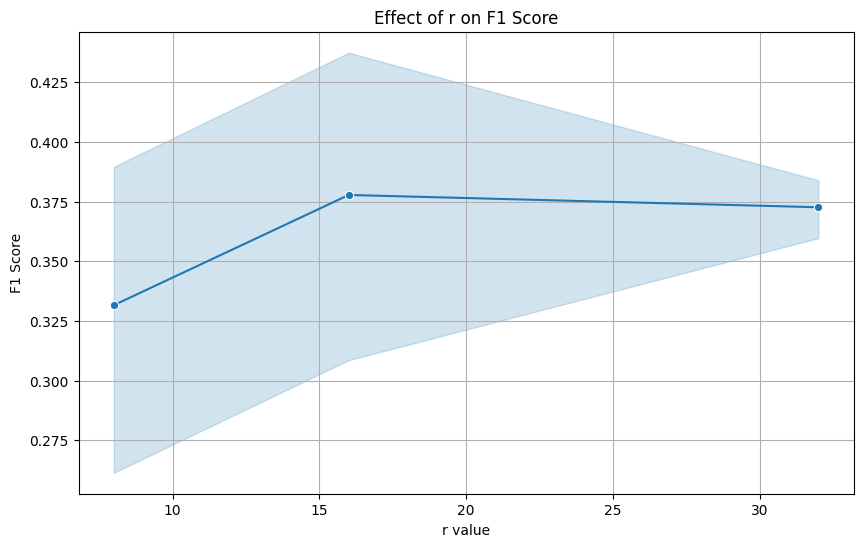

In [12]:

df = pd.read_csv('results_cross_validation.csv')
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='r', y='eval_f1', marker='o')
plt.title('Effect of r on F1 Score')
plt.xlabel('r value')
plt.ylabel('F1 Score')
plt.grid(True)
plt.savefig('r_on_F1_Score.pdf', format='pdf')
plt.show()

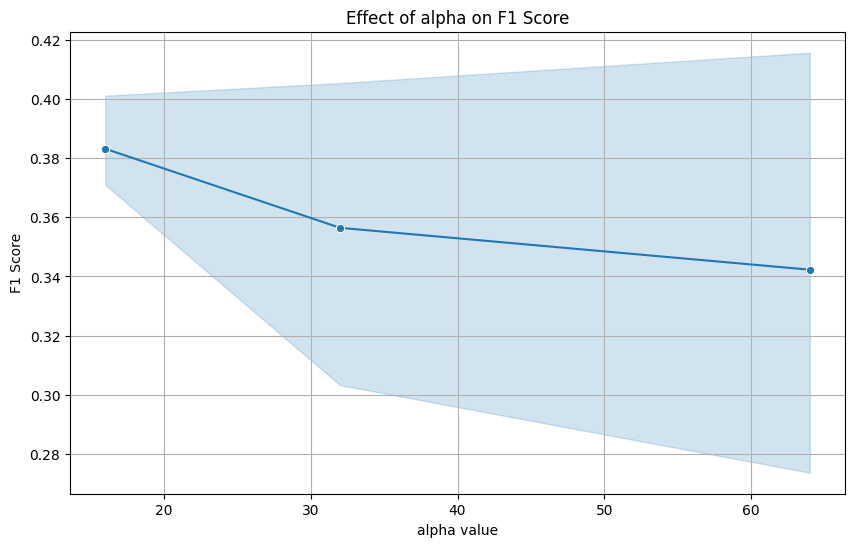

In [13]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='alpha', y='eval_f1', marker='o')
plt.title('Effect of alpha on F1 Score')
plt.xlabel('alpha value')
plt.ylabel('F1 Score')
plt.grid(True)
plt.savefig('alpha_on_F1_Score.pdf', format='pdf')
plt.show()

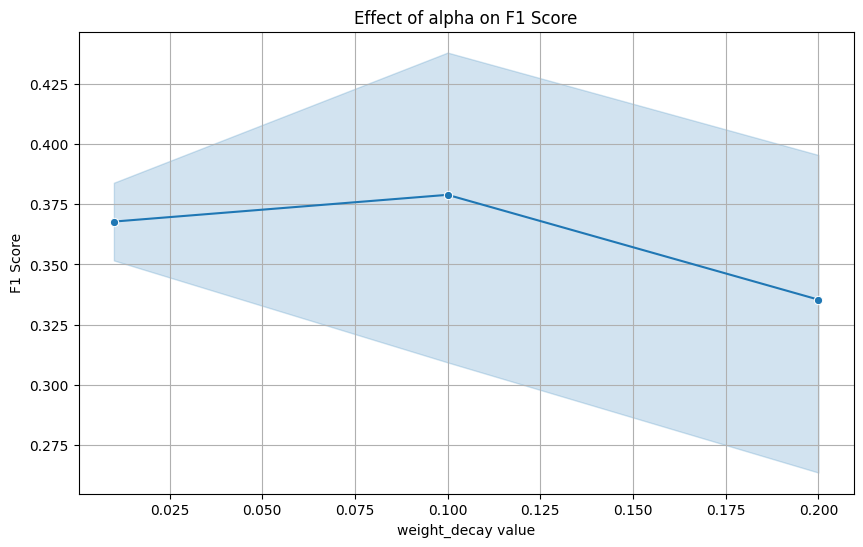

In [11]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='weight_decay', y='eval_f1', marker='o')
plt.title('Effect of alpha on F1 Score')
plt.xlabel('weight_decay value')
plt.ylabel('F1 Score')
plt.grid(True)
plt.savefig('weight_decay_on_F1_Score.pdf', format='pdf')
plt.show()